In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from catboost import CatBoost
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

Зафиксирую random seed

In [2]:
rs = 1385 

Собрал воедино график работы по сменам, отчеты выручки по датам, скачал сводку погоды на этот промежуток времени

In [56]:
df = pd.read_csv('C:\Games\Learnin\Выручка-бариста.csv', header=1)

In [57]:
df = df.fillna('0')

<AxesSubplot:>

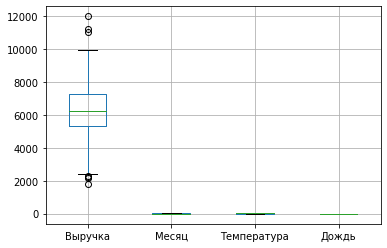

In [5]:
df.boxplot()

In [6]:
df.shape

(454, 7)

Z-score и 2 сигма

In [58]:
z = stats.zscore(df['Выручка'])

In [59]:
bd = list(np.where(abs(z) >2)[0])

In [60]:
dfz = df.drop(index=bd)

In [10]:
dfz.describe()

,Выручка,Месяц,Температура,Дождь
count,432.000000,432.000000,432.000000,432.000000
mean,6277.430556,6.444444,10.898380,0.342593
std,1346.993256,3.104770,10.821842,0.475127
min,3150.000000,1.000000,-17.400000,0.000000
25%,5398.750000,4.000000,2.000000,0.000000
50%,6250.000000,6.000000,11.150000,0.000000
75%,7290.000000,9.000000,19.300000,1.000000
max,9360.000000,12.000000,33.600000,1.000000


<AxesSubplot:>

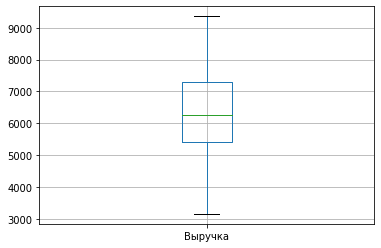

In [11]:
dfz.boxplot(column='Выручка')

Квартили и 3 сигма

In [12]:
Q1 =  df['Выручка'].quantile(0.25)
Q3 = df['Выручка'].quantile(0.75)
IQR = Q3 - Q1

<AxesSubplot:>

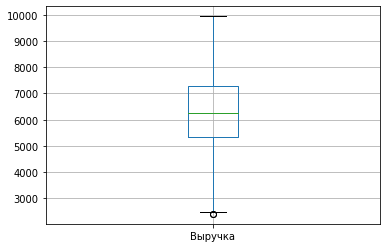

In [13]:
dfq = df[(df['Выручка'] > Q1-1.5*IQR) & (df['Выручка'] < Q3+1.5*IQR)]
dfq.boxplot(column="Выручка")

In [14]:
dfq.describe()

,Выручка,Месяц,Температура,Дождь
count,447.000000,447.000000,447.000000,447.000000
mean,6267.762864,6.467562,10.965772,0.340045
std,1473.138228,3.092476,10.760291,0.474255
min,2400.000000,1.000000,-17.400000,0.000000
25%,5342.500000,4.000000,2.300000,0.000000
50%,6250.000000,6.000000,11.200000,0.000000
75%,7300.000000,9.000000,19.300000,1.000000
max,9950.000000,12.000000,33.600000,1.000000


In [15]:
dfz.shape

(432, 7)

In [16]:
dfq.shape

(447, 7)

Мне больше нравится 2 сигма (dfz df) т.к. так мы уберем больше явных выбросов

In [61]:
df =pd.DataFrame(dfz)

In [62]:
dff = pd.DataFrame(df['Выручка'])

Можно поглядеть на график

In [148]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    rolling_std =  series.rolling(window=n).std()
    upper_bond = rolling_mean+2*rolling_std
    lower_bond = rolling_mean-2*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(dff[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

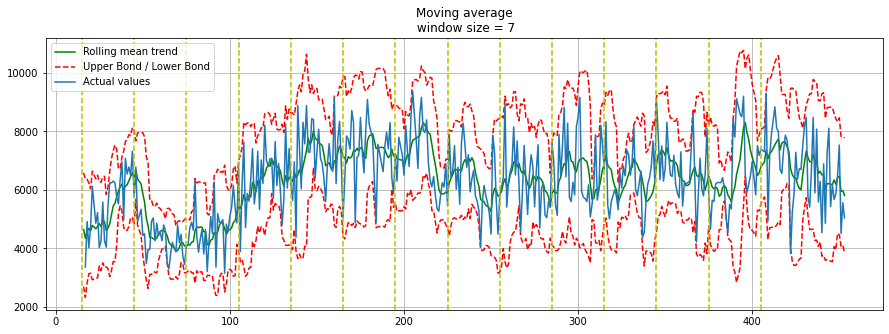

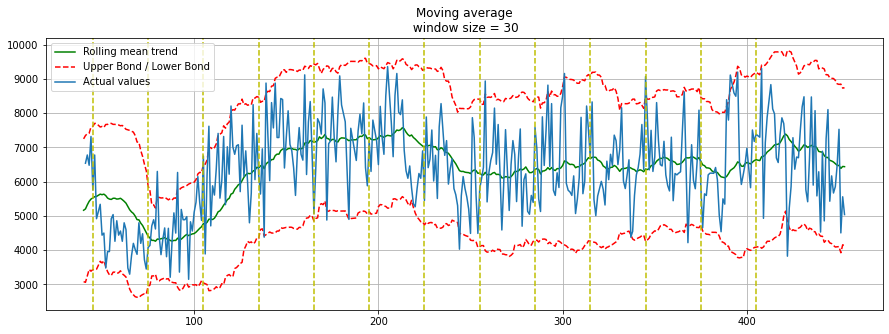

In [149]:
plotMovingAverage(dff, 7) # сглаживаем по неделям
x = 15
while x < len(df):
    plt.axvline(x, c='y', ls='--')
    x = x + 30
plotMovingAverage(dff, 30) # сглаживаем по месецам
x = 45
while x < len(df):
    plt.axvline(x, c='y', ls='--')
    x = x + 30



Конец просмотра

In [63]:
target = df['Выручка']

In [64]:
df = df.drop(columns='Выручка')

In [65]:
df['Температура'].describe()

count    432.000000
mean      10.898380
std       10.821842
min      -17.400000
25%        2.000000
50%       11.150000
75%       19.300000
max       33.600000
Name: Температура, dtype: float64

Поделим на категории во избежание переобучения

In [22]:
bins = [-50, 0, 15, 25, 50]
labels = [1, 2, 3, 4]
df['Температура'] = pd.cut(df['Температура'], bins=bins, labels=labels)

In [23]:
df['Температура']

0      2
1      2
12     3
13     3
14     3
      ..
449    3
450    3
451    3
452    2
453    3
Name: Температура, Length: 432, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

Моделька

In [155]:
#cbr = CatBoostRegressor(iterations=1000, random_seed=rs, loss_function='RMSE')
#выдавал ~те же результаты что и catboost, потому не увидел в нем смысла

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=0.7, test_size=0.3, random_state=rs)

In [76]:
X_train.shape

(302, 5)

In [77]:
df.columns

Index(['Девочка', 'Мальчик', 'Месяц', 'Дождь', 'День недели'], dtype='object')

gs Сatboost

In [84]:
cat_features = ['Месяц', 'Температура', 'Дождь', 'День недели']

In [79]:
pool = Pool(X_train, y_train, cat_features=cat_features, feature_names=list(X_train.columns))

In [181]:
#grid = {'learning_rate': [0.03, 0.05, 0.1],
#        'depth': [2, 4, 6, 10],
#        'l2_leaf_reg': [1, 3, 5, 7, 9]} чем глубже, тем сильнее переобучение, тем хуже тест

grid = {'learning_rate': [0.03, 0.05],
        'depth': [2, 3, 4],
        'l2_leaf_reg': [1, 2, 3]}

cbm не умеет в grid лосс функций

Тест лоссфункций вручную, уже известно что лучшими показателями на отложенной выборке оказались lr=0.05, d=3, l2lr=1

In [114]:
paramas = {'iterations':5000, 'learning_rate':0.05, 'depth':3, 'l2_leaf_reg':1, 'loss_function':'Huber:delta=3.5', 'metric_period':5} #'logging_level':'Info' 
#shrink(n) чтобы обрезать до переобучения

In [111]:
ggb = CatBoost(params=paramas) #od_type='Iter', od_wait=20 - стоп если на 20 итерациях не было улучшения, eval_metric='name' если другая метрика

In [112]:
ggbres = ggb.fit(pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 21980.7480953	total: 11.9ms	remaining: 59.3s
5:	learn: 21563.8424599	total: 111ms	remaining: 1m 32s
10:	learn: 20998.2372363	total: 187ms	remaining: 1m 24s
15:	learn: 20428.7298602	total: 313ms	remaining: 1m 37s
20:	learn: 19853.1258781	total: 364ms	remaining: 1m 26s
25:	learn: 19414.8719809	total: 430ms	remaining: 1m 22s
30:	learn: 18952.9374541	total: 489ms	remaining: 1m 18s
35:	learn: 18425.6641847	total: 561ms	remaining: 1m 17s
40:	learn: 17893.8113622	total: 610ms	remaining: 1m 13s
45:	learn: 17461.5567200	total: 691ms	remaining: 1m 14s
50:	learn: 16848.2738466	total: 751ms	remaining: 1m 12s
55:	learn: 16366.5405613	total: 834ms	remaining: 1m 13s
60:	learn: 15833.2436990	total: 949ms	remaining: 1m 16s
65:	learn: 15427.3184446	total: 1.02s	remaining: 1m 16s
70:	learn: 15112.1892181	total: 1.16s	remaining: 1m 20s
75:	learn: 14662.4195094	total: 1.31s	remaining: 1m 24s
80:	learn: 13960.4661049	total: 1.35s	remaining: 1m 22s
85:	learn: 13443.7026866	total: 1.42s	remaining: 1

In [118]:
ggb.tree_count_

5000

_______________________________________________________________
Рандомный кусочек статьи про катбуст и rmse - std - насколько хороша модель
https://towardsdatascience.com/how-do-you-use-categorical-features-directly-with-catboost-947b211c2923
_______________________________________________________________

In [115]:
cb_rmse = np.sqrt(mean_squared_error(y_test, ggb.predict(X_test)))
print("RMSE in y units:", np.mean(cb_rmse))

RMSE in y units: 1180.3029471625516


In [91]:
target.describe()

count     432.000000
mean     6277.430556
std      1346.993256
min      3150.000000
25%      5398.750000
50%      6250.000000
75%      7290.000000
max      9360.000000
Name: Выручка, dtype: float64

Получается, что Модель в среднием ошибается ~на стандартное отклонение

_______________________________________________________________
Рандомный кусочек статьи про катбуст и rmse - std - насколько хороша модель
https://towardsdatascience.com/how-do-you-use-categorical-features-directly-with-catboost-947b211c2923
_______________________________________________________________

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
lr = LinearRegression()

In [49]:
X_train

,Девочка,Мальчик,Месяц,Температура,Дождь,День недели
129,0,1.0,9,2,0,1
385,1.0,0,5,2,1,6
65,0,1.0,7,4,0,2
311,0,1.0,3,2,0,0
21,0,1.0,5,2,0,4
...,...,...,...,...,...,...
35,1.0,0,6,3,0,4
118,1.0,0,8,2,1,3
286,1.0,0,2,2,0,5
416,0,1.0,6,4,0,0


In [116]:
mean_squared_error(y_test, ggb.predict(X_test))

1393115.0470806053

RMSE 1562997.20 <br/>
MAE 1471720.65 <br/>
MAPE 1414749.41 <br/>
Quantile 1471720.65 <br/>
Huber 15155710.68 0.2 <br/>
Huber  5083909.92 0.5 <br/>
Huber  2377977.18 0.8 <br/>
Huber  1997919.79 0.9 <br/>
Huber  1888333.05 0.95<br/>
Huber  1403189.48 1.5 <br/>
Huber  1312537.61 3.0 <br/>
Huber  1322864.04 5.0 <br/>
Huber  1309875.98 3.5 <br/>
Huber  1402136.98 3.5  без столбца "температура"<br/>
Тут уже быстро выходит на асимптоту и не обучается дальше

Кол-во итераций вносит минимальный вклад в качество

Конец теста лоссфункций, делитну потом

In [169]:
gscb = CatBoost()

In [170]:
gsresult = gscb.grid_search(grid, X=pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6321.5798069	test: 6025.6976307	best: 6025.6976307 (0)	total: 8.3ms	remaining: 8.29s
1:	learn: 6143.9683070	test: 5848.3643035	best: 5848.3643035 (1)	total: 17.9ms	remaining: 8.95s
2:	learn: 5971.8567649	test: 5676.4484837	best: 5676.4484837 (2)	total: 27ms	remaining: 8.96s
3:	learn: 5803.9535725	test: 5508.6443849	best: 5508.6443849 (3)	total: 41.4ms	remaining: 10.3s
4:	learn: 5641.3281181	test: 5346.1360534	best: 5346.1360534 (4)	total: 54.5ms	remaining: 10.8s
5:	learn: 5483.6165644	test: 5188.2549492	best: 5188.2549492 (5)	total: 118ms	remaining: 19.5s
6:	learn: 5332.0702703	test: 5036.9419589	best: 5036.9419589 (6)	total: 130ms	remaining: 18.4s
7:	learn: 5183.7357495	test: 4888.8372311	best: 4888.8372311 (7)	total: 137ms	remaining: 17s
8:	learn: 5041.6567415	test: 4747.2615021	best: 4747.2615021 (8)	total: 164ms	remaining: 18.1s
9:	learn: 4903.0759236	test: 4616.9598504	best: 4616.9598504 (9)	total: 194ms	remaining: 19.2s
10:	learn: 4769.9725939	test: 4483.7424234	best: 4

In [176]:
gsresult['params']

{'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.05}

In [178]:
params = {'learning_rate':0.05, 'depth':3, 'l2_leaf_reg':1}

In [184]:
cbm = CatBoost(params=params)

In [185]:
cbm.fit(pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1378.6693598	total: 29.1ms	remaining: 29.1s
1:	learn: 1368.5483927	total: 72.1ms	remaining: 36s
2:	learn: 1359.2033679	total: 124ms	remaining: 41.1s
3:	learn: 1352.1024665	total: 163ms	remaining: 40.6s
4:	learn: 1343.6160299	total: 225ms	remaining: 44.7s
5:	learn: 1337.5529813	total: 329ms	remaining: 54.6s
6:	learn: 1331.6413564	total: 404ms	remaining: 57.3s
7:	learn: 1322.1266694	total: 486ms	remaining: 1m
8:	learn: 1312.9755089	total: 521ms	remaining: 57.3s
9:	learn: 1306.0454233	total: 597ms	remaining: 59.1s
10:	learn: 1301.7867125	total: 628ms	remaining: 56.5s
11:	learn: 1295.4071738	total: 669ms	remaining: 55.1s
12:	learn: 1287.3616045	total: 722ms	remaining: 54.8s
13:	learn: 1281.7165831	total: 811ms	remaining: 57.1s
14:	learn: 1276.0738733	total: 830ms	remaining: 54.5s
15:	learn: 1272.2740504	total: 895ms	remaining: 55.1s
16:	learn: 1268.9223802	total: 927ms	remaining: 53.6s
17:	learn: 1266.5856379	total: 1.03s	remaining: 56.2s
18:	learn: 1263.2449341	total: 1.05s	rema

In [250]:
mean_squared_error(y_test, cbm.predict(X_test))

1977023.451520953

In [252]:
cbm.predict([0, 1, 8, 3, 0, 'вт'])

5256.636075086259

Random Forest Regressor

In [44]:
le = LabelEncoder()

In [45]:
df['День недели'] = le.fit_transform(df['День недели'])

In [255]:
ohe = OneHotEncoder()

In [257]:
df = df.astype(int)

In [266]:
sosok = ohe.fit_transform(df)

In [267]:
X_test1, X_train1, y_test1, y_train1 = train_test_split(sosok, target, test_size=0.75, train_size=0.25, random_state=rs)

In [260]:
rfr = RandomForestRegressor(n_estimators=300, max_leaf_nodes=5, min_samples_leaf=10, random_state=rs)

In [264]:
X_test['День недели'] = le.fit_transform(X_test['День недели'])

In [268]:
rfr.fit(X_train1, y_train1)

RandomForestRegressor(max_leaf_nodes=5, min_samples_leaf=10, n_estimators=300,
                      random_state=1385)

In [269]:
rfr.score(X_test1, y_test1)

0.2551735284109895

In [270]:
mean_squared_error(rfr.predict(X_test1), y_test1)

1693339.9862246977

Разница предикта и истинных значений

In [271]:
ako = rfr.predict(X_test1) - y_test1

In [272]:
ako = pd.DataFrame(ako)

In [273]:
ako.describe()

,Выручка
count,113.000000
mean,1.315829
std,1307.079702
min,-4031.455725
25%,-811.304563
50%,174.575613
75%,893.920764
max,2893.069768


In [274]:
rfr.feature_importances_

array([8.44798269e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.16201204e-03, 8.22412925e-04, 0.00000000e+00, 2.93115630e-04,
       3.63224352e-01, 2.76665999e-02, 1.66613916e-01, 4.58935728e-02,
       0.00000000e+00, 3.35268905e-02, 6.89784169e-02, 0.00000000e+00,
       5.83771032e-04, 3.27440602e-02, 1.85098817e-02, 2.21484590e-01,
       5.56557769e-03, 5.69607159e-03, 2.95506697e-04, 1.00835120e-03,
       0.00000000e+00, 1.91784528e-04, 7.43721139e-04, 0.00000000e+00,
       1.15059662e-03])

Сложноинтерпретируемые веса

Блендинг двух моделей

In [275]:
def select_weights(y_true, y_pred_1, y_pred_2):
    metric = []
    grid = np.linspace(0, 1, 1000)
    for w_0 in grid:
      w_1 = 1 - w_0
      y = y_pred_1 * w_0 + y_pred_2 * w_1

      metric.append([mean_squared_error(y_true, y), w_0, w_1])

    return metric

In [276]:
rmse_blending_train, w_0, w_1 = min(select_weights(y_test, rfr.predict(X_test1), cbm.predict(X_test)), key=lambda x: x[0])

In [277]:
rmse_blending_train

1680857.2922047905

In [278]:
w_0, w_1

(0.8718718718718719, 0.12812812812812813)

In [280]:
mean_squared_error(y_test, rfr.predict(X_test1))

1693339.9862246977

In [282]:
mean_squared_error(y_test, rfr.predict(X_test1)*w_0+cbm.predict(X_test)*w_1)

1680857.2922047905

In [283]:
blendingres = rfr.predict(X_test1)*w_0+cbm.predict(X_test)*w_1 - y_test

In [284]:
blendingres.describe()

count     113.000000
mean      -89.149648
std      1299.171400
min     -4105.460801
25%      -933.214214
50%        96.544698
75%       826.456936
max      2786.142473
Name: Выручка, dtype: float64

min-max range = 6900 <br/>
std = 1300

________________________________________________________________________________________________
The range (max-min) is 18497. The standard deviation is 3989. So, the RMSE value we got is a really good one for our model. Also, note that we got this value without doing any hyperparameter tuning!
___________________________________________________________________________________________________

Одна из проблем деревьев - они не могут предсказывать значения выше ранее виденных
Т.е. дерево не сможет предсказать значение выручки выше 9500

In [1]:
pipe = Pipeline([
    ('le+ohe', le.fit_transform(X_test['День недели'])),
    ('ohe', sosok = ohe.fit_transform(df)),
    ('model1', RandomForestRegressor(n_estimators=300, max_leaf_nodes=5, min_samples_leaf=10, random_state=rs)),
    ('model2', CatBoost(params=params)) #нужно оттестить так ли класть сюда параметры
])